# Initialization

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import time
import joblib

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
RANDOM_STATE = 0
N_JOBS = 6

# Reading final test data

In [3]:
final_test_df = pd.read_csv("data/processed/test_language_detection_dataset.csv")
final_test_df.head()

,sentence,lan_code
0,Tom couldn't believe how ugly Mary became as s...,eng
1,I'm ready to go now.,eng
2,Что у тебя на этой грядке?,rus
3,"""Он говорит, что хочет есть.""",rus
4,Я решил туда пойти.,rus


In [4]:
X_final_test = final_test_df["sentence"]
y_final_test = final_test_df["lan_code"]

# Initializing models

Here we're gonna initialize our own models as well as three pre-trained popular models for language detection - Lingua, fast-langdetect and XLM-RoBERTa, all of which feature all 3 of our languages, to compare perfomance of our models with already existing ones.

In [9]:
from app.models.transformers import TextCleaner

## SGDClassifier-based model

In [10]:
sgd_model_path = "models/dev/sgd_language_detection_model.joblib"

In [11]:
sgd_model = joblib.load(sgd_model_path)
sgd_model

,clf,Pipeline(step...om_state=0))])
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None
,stop_words,None
,token_pattern,'(?u)\\b\\w\\w+\\b'
,ngram_range,"(1, ...)"


In [12]:
def detect_languages_sgd(series: pd.Series) -> pd.Series:
    y_pred = sgd_model.predict(series)
    return y_pred

## MultinomialNB-based model

In [13]:
mnb_model_path = "models/dev/mnb_language_detection_model.joblib"

In [14]:
mnb_model = joblib.load(mnb_model_path)
mnb_model

,clf,Pipeline(step...rior=False))])
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None
,stop_words,None
,token_pattern,'(?u)\\b\\w\\w+\\b'
,ngram_range,"(1, ...)"


In [15]:
def detect_languages_mnb(series: pd.Series) -> pd.Series:
    text_cleaner = TextCleaner(mode="no_punct")
    series_cleaned = text_cleaner.fit_transform(series)
    y_pred = mnb_model.predict(series_cleaned)
    return y_pred

## Lingua

In [16]:
from lingua import Language, LanguageDetectorBuilder

In [17]:
languages = [Language.ENGLISH, Language.RUSSIAN, Language.UKRAINIAN]
lingua_detector = LanguageDetectorBuilder.from_languages(*languages).build()

In [18]:
def detect_languages_lingua(series: pd.Series) -> pd.Series:
    codes_map = {
        "en" : "eng",
        "ru" : "rus",
        "uk" : "ukr"
    }

    def get_lang_code(text):
        if not isinstance(text, str) or not text.strip():
            return None
            
        res = lingua_detector.detect_language_of(text)
        
        # Convert Enum to string ISO code (e.g., Language.ENGLISH -> 'EN')
        if res:
            return codes_map[res.iso_code_639_1.name.lower()]
        return "unknown"

    results = series.apply(get_lang_code)

    result_df = pd.DataFrame(results.tolist(), columns=['detected_lang'], index=series.index)
    
    return result_df

## fast-langdetect

In [19]:
from fast_langdetect import detect

In [20]:
def detect_languages_fast_langdetect(series: pd.Series) -> pd.Series:
    clean_series = series.astype(str).str.replace('\n', ' ', regex=False).fillna('')

    codes_map = {
        "en" : "eng",
        "ru" : "rus",
        "uk" : "ukr"
    }

    def safe_detect(text):
        if not text or text.isspace():
            return 'unknown'
        try:
            result = detect(text, model="auto", k=1)
            return codes_map[result[0]['lang']]
        except Exception as e:
            return 'unknown'

    results = clean_series.apply(safe_detect)

    result_df = pd.DataFrame(results.tolist(), columns=['detected_lang'], index=series.index)
    
    return result_df

## XLM-RoBERTa

TBD.

# Testing

In [21]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report, \
                            accuracy_score, recall_score, precision_score

In [22]:
predictors = {
    "sgd": detect_languages_sgd,
    "mnb": detect_languages_mnb,
    "lingua": detect_languages_lingua,
    "fast-langdetect": detect_languages_fast_langdetect
}

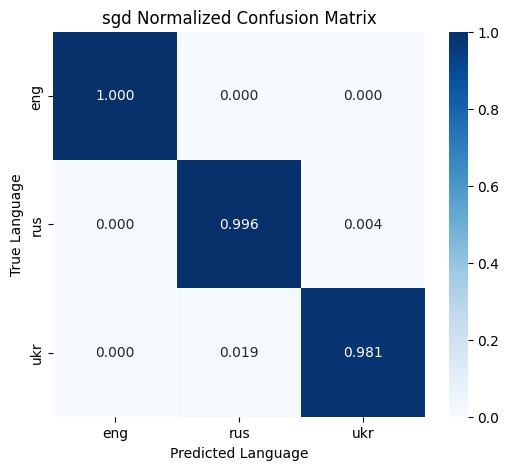

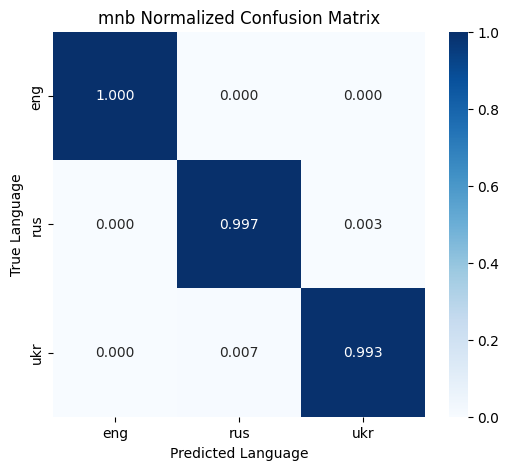

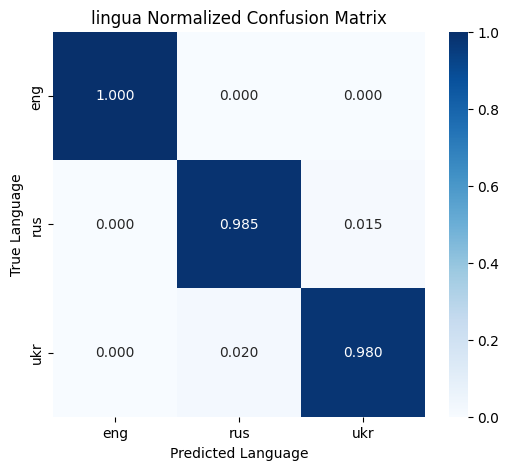

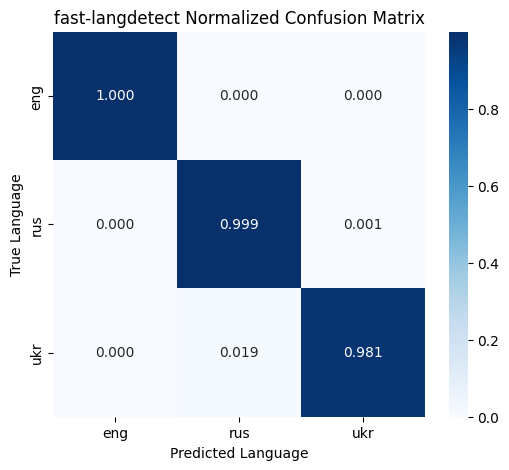

In [23]:
results = []

valid_labels = np.unique(y_final_test)

for name, predictor in predictors.items():
    start_time = time.time()
    
    preds = predictor(X_final_test)
    
    end_time = time.time()
    elapsed = end_time - start_time
    samples_per_sec = len(X_final_test) / elapsed if elapsed > 0 else 0
    
    macro_f1 = f1_score(y_final_test, preds, average='macro', labels=valid_labels, zero_division=0)
    accuracy = accuracy_score(y_final_test, preds)
    
    recalls = recall_score(y_final_test, preds, average=None, labels=valid_labels, zero_division=0)
    precisions = precision_score(y_final_test, preds, average=None, labels=valid_labels, zero_division=0)
    
    row = {
        "Model": name,
        "Macro F1": macro_f1,
        "Accuracy": accuracy,
        "Speed (samples/sec)": int(samples_per_sec)
    }
    
    for i, label in enumerate(valid_labels):
        row[f"{label} Recall"] = recalls[i]
        row[f"{label} Precision"] = precisions[i]
        
    results.append(row)

    cm = confusion_matrix(y_final_test, preds, labels=valid_labels, normalize='true')
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='.3f', 
        cmap='Blues',
        xticklabels=valid_labels,
        yticklabels=valid_labels
    )
    plt.xlabel("Predicted Language")
    plt.ylabel("True Language")
    plt.title(f'{name} Normalized Confusion Matrix')
    plt.show()

In [24]:
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="Macro F1", ascending=False).reset_index(drop=True)
results_df

,Model,Macro F1,Accuracy,Speed (samples/sec),eng Recall,eng Precision,rus Recall,rus Precision,ukr Recall,ukr Precision
0,mnb,0.995939,0.998636,13285,1.000000,0.999996,0.997368,0.998624,0.992982,0.986683
1,fast-langdetect,0.994584,0.997402,56021,0.999077,0.999996,0.998231,0.996300,0.978274,0.995782
2,sgd,0.992616,0.997514,14650,1.000000,0.999958,0.996374,0.996330,0.981223,0.981809
3,lingua,0.981599,0.993700,27587,1.000000,0.999962,0.985407,0.996054,0.979991,0.929570


In [25]:
analysis_df = pd.DataFrame({
    'text': X_final_test.values,
    'true_label': y_final_test,
    'predicted': predictors["mnb"](X_final_test)
})

false_english = analysis_df[
    (analysis_df['predicted'] == 'eng') & 
    (analysis_df['true_label'] != 'eng')
]

false_english

,text,true_label,predicted
110325,Он пробовал написать один небольшой рассказ.\r...,rus,eng


In [29]:
false_english["text"].iloc[0]

'Он пробовал написать один небольшой рассказ.\r 479300,cycl,(cost (TheFn (SubcollectionOfWithRelationToTypeFn Chair-PieceOfFurniture primaryConstituent Wood)) Expensive)'

# TODO:
1. Resolve the problem with corrupted .csv files.
2. Retrain all models (because of 1.)
3. Add XLM-RoBERTa to comparison.